![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 002 - Part II

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 16/08/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_08/Exercise0002Part002.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp

# Machine Learning

# Computer Vision
from skimage.color import rgb2lab
from skimage.io import imread
from skimage.segmentation import mark_boundaries

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
%matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

DATA_FILE_URL   = r'https://github.com/FixelAlgorithmsTeam/FixelCourses/raw/master/MachineLearningMethod/16_ParametricClustering/Fruits.jpeg'
DATA_FILE_NAME  = r'Fruits.jpeg'

TOTAL_RUN_TIME = 45 #<! Don't touch it!


## Guidelines

 - Fill the full names and ID's of the team members in the `Team Members` section.
 - Answer all questions / tasks within the Jupyter Notebook.
 - Use MarkDown + MathJaX + Code to answer.
 - Verify the rendering on VS Code.
 - Submission in groups (Single submission per group).
 - You may and _should_ use the forums for questions.
 - Don't use `pip install` on the submitted notebook!  
   If you need a package that is not imported above use **the dedicated cell**.
 - Good Luck!

<font color='red'>Total run time must be **less than `TOTAL_RUN_TIME` seconds**</font>.

In [4]:
# Run Time
print(f'The total run time must not exceed: {TOTAL_RUN_TIME} [Sec]')
startTime = time.time()

The total run time must not exceed: 45 [Sec]


## Team Members

 - `Ori_Blanka_208994764`.
 - `Or_Benson_308577345`.
 - `Alon_Hertz_315682773`.

* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.

## Generate / Load Data

In [5]:
# Download Data
# This section downloads data from the given URL if needed.

if not os.path.exists(DATA_FILE_NAME):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 6. Clustering by K-Means

### 6.1. K-Means Algorithm

In this section we'll implement 3 functions related to the K-Means:

1. `InitKMeans()` - Given a data set and number of clusters it sets the initialization of the `K-Means` algorithm.  
It should support both random initialization (Samples from data) and the [`K-Means++`](https://en.wikipedia.org/wiki/K-means%2B%2B) initialization.
2. `CalcKMeansObj()` - Given a data set and set of centroids it calculates the value of the K-Means objective function (Usually called `inertia`).  
   The objective function sum of squared distances of samples to their closest cluster center.
3. `KMeans()` - Given a data set and initialization applies the K-Means algorithm.  
The distance used in this variant is the Euclidean Distance based.

* <font color='brown'>(**#**)</font> Implementation should be efficient (Memory and operations). Total run time expected to be **less than 60 seconds**.



In [6]:
#===========================Fill This===========================#
def InitKMeans(mX: np.ndarray, K: int, initMethod: int = 0, seedNum: int = 123) -> np.ndarray:
    '''
    K-Means algorithm initialization.
    Args:
        mX          - Input data with shape N x d.
        K           - Number of clusters.
        initMethod  - Initialization method: 0 - Random, 1 - K-Means++.
        seedNum     - Seed number used.
    Output:
        mC          - The initial centroids with shape K x d.
    Remarks:
        - Given the same parameters, including the `seedNum` the algorithm must be reproducible.
    '''
    # Set random seed for reproducibility
    np.random.seed(seedNum)
    
    # Initialize centroids array
    mC = np.zeros((K, mX.shape[1]))

    if initMethod == 0: # Random initialization
        
        # Select K random samples as initial centroids
        random_indices = np.random.choice(len(mX), K, replace=False)
        mC = mX[random_indices]
        
    elif initMethod == 1: # K-Means++ initialization
        
        # Select first centroid randomly
        idx = np.random.randint(len(mX))
        mC[0] = mX[idx]
        
        # Compute distances between points and current centroids
        dists = np.linalg.norm(mX - mC[0], axis=1)
        
        for k in range(1, K):
            
            # Compute distribution from distances
            probs = dists**2
            probs /= probs.sum()
            
            # Sample next centroid index based on distribution
            idx = np.random.choice(len(mX), p=probs) 
            
            # Update centroid and distance calculations
            mC[k] = mX[idx]
            cur_dist = np.linalg.norm(mX - mC[k], axis=1)
            dists = np.minimum(dists, cur_dist)
            
    return mC
#===============================================================#

In [7]:
#===========================Fill This===========================#
def CalcKMeansObj(mX: np.ndarray, mC: np.ndarray) -> float:
    '''
    K-Means algorithm.
    Args:
        mX          - The data with shape N x d.
        mC          - The centroids with shape K x d.
    Output:
        objVal      - The value of the objective function of the KMeans.
    Remarks:
        - The objective function uses the squared euclidean distance.
    '''
    
    # Calculate squared euclidean distance between each point and each centroid
    dists = np.linalg.norm(mX[:,np.newaxis,:] - mC[np.newaxis,:,:], axis=2)**2
    
    # Find closest centroid for each point
    min_dists = np.min(dists, axis=1)
    
    # Sum the distances for all points
    objVal = np.sum(min_dists)
    
    return objVal
    
#===============================================================#

In [8]:
#===========================Fill This===========================#
def KMeans(mX: np.ndarray, mC: np.ndarray, numIter: int = 1000, stopThr: float = 0) -> np.ndarray:
    '''
    K-Means algorithm.
    Args:
        mX          - Input data with shape N x d.
        mC          - The initial centroids with shape K x d.
        numIter     - Number of iterations.
        stopThr     - Stopping threshold.
    Output:
        mC          - The final centroids with shape K x d.
        vL          - The labels (0, 1, .., K - 1) per sample with shape (N, )
        lO          - The objective value function per iterations (List).
    Remarks:
        - The maximum number of iterations must be `numIter`.
        - If the objective value of the algorithm doesn't improve by at least `stopThr` the iterations should stop.
    '''

    lO = []
    K = mC.shape[0]

    for i in range(numIter):
        # Compute distances between all points and centroids
        dists = np.linalg.norm(mX[:,np.newaxis,:] - mC[np.newaxis,:,:], axis=2)
        vL = np.argmin(dists, axis=1)
        lO.append(CalcKMeansObj(mX, mC))
        if i > 0 and abs(lO[-1] - lO[-2]) < stopThr:
            return mC, vL, lO
        
        # Update centroids as cluster means
        mC = np.stack([mX[vL==k].mean(axis=0) for k in range(K)], axis=0)
        
    return mC, vL, lO

#===============================================================#

### 6.2. Super Pixels

In this section we'll implement the Super Pixels segmentation algorithm.  
The basic idea of the _super pixels_ segmentation is to cluster together pixels which share similar color and location.  
Hence the features to cluster are the color values of the pixel and its coordinates.

Your code should follow:

1. Load the `Fruits.jpg` image into a NumPy array `mI` with shape `numRows x numCols x 3`.  
   The image will be downloaded into the local folder automatically by a supplied code.  
   If it doesn't work, look at the constant `DATA_FILE_NAME`.
   You may use `SciKit Image`'s `imread()` (Imported above).
2. Convert the image into the [LAB Color Space](https://en.wikipedia.org/wiki/CIELAB_color_space).  
   **No need to implement the conversion manually**.  
   You may use `SciKit Image`'s `rgb2lab()` (Imported above).
3. Create the data array `mX` with shape `(numRows * numCols) x 5`.  
   The features should include the LAB values and the row / column coordinates of each pixel.
4. Scale the columns of data in a reasonable manner.
5. Apply the K-Means algorithm on the data with `K-Means++` initialization.    
   Set a reasonable number of clusters (Trial and error).  
   Set the parameters of the algorithm such that the algorithm stops on convergence (No change in centroids).
6. Create a mask of the labels of the pixels at the size of the image.  
   Display the results using `SciKit Image`'s `mark_boundaries()` (Imported above).
7. Display the segmentation result.
8. Display the objective function per iteration. Including the initialization.

The output should look similar to:

![](https://i.imgur.com/BS6sVXc.png)

* <font color='brown'>(**#**)</font> Use different cells per steps.
* <font color='brown'>(**#**)</font> Optimize the weights (Scaling).

In [9]:
#===========================Fill This===========================#
# 1. Load Image into `mI`.
# 2. Convert to LAB (`mILab`).

mI = imread(DATA_FILE_NAME)
mILab = rgb2lab(mI)
#===============================================================#

In [10]:
#===========================Fill This===========================#
# 1. Generate `mX` from `mILab`.
# 2. Scale its columns in a reasonable way.

# Get grid of x,y coordinates 
y, x = np.indices(mI.shape[:2])

# Stack x,y,label arrays along third axis
mX = np.dstack([mILab, x, y]).reshape(-1, 5)

# Scale x,y columns
SCALING_FACTOR = 1.5
mX[:,3:] *= SCALING_FACTOR
#===============================================================#

In [11]:
#===========================Fill This===========================#
# 1. Apply K-Means clustering on `mX`.
# 2. Build the mask from the labels.

K = 40
mC = InitKMeans(mX, K, initMethod=1, seedNum=seedNum)
mC, vL, lO = KMeans(mX, mC, numIter=30)
mMask = vL.reshape(mI.shape[:2])

#===============================================================#

Text(0.5, 1.0, 'Super Pixels Image')

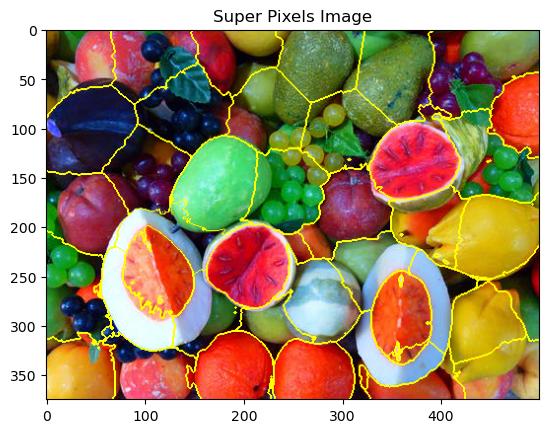

In [12]:
#===========================Fill This===========================#
# 1. Generate the super pixel boundaries form the mask.
# 2. Display the results (Super Pixels Image, Objective function vs. iteration).

# Make sure to show the objective function of the initialization in the graph.

plt.imshow(mark_boundaries(mI, mMask))
plt.title('Super Pixels Image')
#===============================================================#

#### 6.2.1. Question

Explain the boundaries between clusters on the image.  
Specifically, why are boundaries curved while in class it was said to be straight lines.

The boundaries between clusters in the image appear curved rather than straight for a few key reasons:

1. The image pixels are being clustered based on RGB color values, which do not have clear linear separations between different color regions. The color gradients result in curved cluster boundaries as colors blend into each other.

2. The k-means algorithm is using Euclidean distance in the RGB color space to assign pixels to clusters. This tends to produce blob-like clusters with curved boundaries rather than hard separations. 

3. The image has likely undergone some preprocessing like smoothing/blurring. This causes colors to bleed into each other, again producing non-linear blended boundaries between color regions.

4. In an ideal simplified case, k-means boundaries between clusters in 2D space can be linear. But for clustering in higher dimensions with real-world data like images, the boundaries are much less likely to be perfectly straight lines.

So in summary, the curved cluster boundaries are a result of the high-dimensional color data, the use of Euclidean distance, and the natural color gradients present in real images. The idealized straight line boundaries are only expected in simple 2D examples, not for clustering real-world image data.

In [13]:
# Run Time
# Check Total Run Time.
# Don't change this!

endTime = time.time()

totalRunTime = endTime - startTime
print(f'Total Run Time: {totalRunTime} [Sec].')

if (totalRunTime > TOTAL_RUN_TIME):
    raise ValueError(f'You have exceeded the allowed run time as {totalRunTime} > {TOTAL_RUN_TIME}')

Total Run Time: 18.022737979888916 [Sec].
